In [26]:
import pandas as pd
import numpy as np
from scipy.stats import genextreme
from matplotlib import pyplot as plt
from datetime import datetime,timedelta

In [27]:
# WAVES 
df_waves = pd.read_csv('input/15432_19815_5024022_ALL_19580103153835_20240219153835.csv',sep='\t',header=1)
df_waves.dropna(axis=0,inplace=True)
df_waves['Fecha (GMT)'] = pd.to_datetime(df_waves['Fecha (GMT)'], format='%Y %m %d %H')

# CURRENTS
df_currents = pd.read_csv('input/15438_19826_1050048_CURRENTS_20110331091150_20240220101150.csv',sep='\t',header=1)
df_currents.dropna(axis=0,inplace=True)
df_currents['Fecha (GMT)'] = pd.to_datetime(df_currents['Fecha (GMT)'], format='%Y %m %d %H')

In [28]:
# CALCULO COM FORMULA BASICA H50 = HSmax + K * SIGMA
MAX = max(df_waves['Altura Signif. del Oleaje(m)'])
SIGMA = np.std(df_waves['Altura Signif. del Oleaje(m)'])
K = 1.281

Hmax50 = MAX + K * SIGMA
print(f"Hs for 50 year period, calculated with simplified Gumbel formula is: {round(Hmax50,2)}")

Hs for 50 year period, calculated with simplified Gumbel formula is: 5.83


In [29]:
# PREPARAR DADOS PARA CÁLCULOS
dates_waves = df_waves['Fecha (GMT)']
waves = df_waves['Altura Signif. del Oleaje(m)']
currents = df_currents['Velocidad media de Corriente(m/s)']
dates_currents = df_currents['Fecha (GMT)']

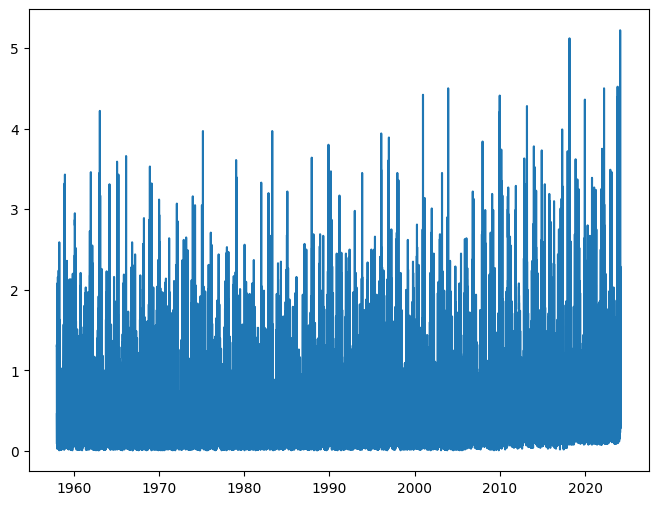

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(dates_waves, waves)

(array([4.16368e+05, 1.03629e+05, 3.73800e+04, 1.31710e+04, 4.85400e+03,
        1.75400e+03, 5.77000e+02, 1.37000e+02, 4.10000e+01, 1.60000e+01]),
 array([0.01 , 0.531, 1.052, 1.573, 2.094, 2.615, 3.136, 3.657, 4.178,
        4.699, 5.22 ]),
 <BarContainer object of 10 artists>)

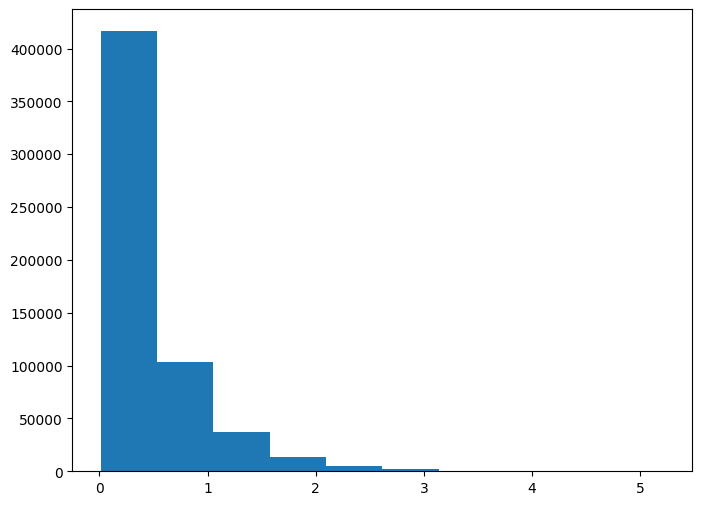

In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(waves)

In [32]:
# Divide 360 direction into bins of 22.5 degrees
bins10 = range(0,3600,225)
bins = [bin / 10 for bin in bins10]

# create column with bins
df_waves['Direction bin'] = pd.cut(df_waves['Direcc. Media de Proced.(0=N,90=E)'],bins)
df_waves['Direction bin'].unique()

[(180.0, 202.5], (202.5, 225.0], (225.0, 247.5], (157.5, 180.0], (135.0, 157.5], ..., (270.0, 292.5], NaN, (315.0, 337.5], (292.5, 315.0], (22.5, 45.0]]
Length: 16
Categories (15, interval[float64, right]): [(0.0, 22.5] < (22.5, 45.0] < (45.0, 67.5] < (67.5, 90.0] ... (247.5, 270.0] < (270.0, 292.5] < (292.5, 315.0] < (315.0, 337.5]]

In [33]:
def get_Hs_return(type,data,period):
    """Function that generates Hs of a certain period"""
    
    # Sort the dataset in ascending order
    data_sorted = np.sort(data)

    # Fit the Gumbel distribution to the dataset
    params = genextreme.fit(data_sorted)

    # Step 3: Extract the fitted parameters (shape parameter c, location parameter loc, and scale parameter scale)
    c = params[0]
    loc = params[1]
    scale = params[2]

    # Calculate the 50-year return period significant wave height
    return_period = period
    return_period_value = genextreme.ppf(1 - 1 / return_period, c, loc, scale)
    
    return return_period_value

In [34]:
# Get past dates
date_10yrs = max(df_waves['Fecha (GMT)']) - 10 * timedelta(days=360)
date_50yrs = max(df_waves['Fecha (GMT)']) - 50 * timedelta(days=360)

# Get sliced dataframes for past dates
df_waves_50 = df_waves[df_waves['Fecha (GMT)']>date_50yrs]
df_waves_10 = df_waves[df_waves['Fecha (GMT)']>date_10yrs]

In [35]:
# WAVES 50-yr
Hs_50 = {}
df_waves_grouped = df_waves_50.groupby('Direction bin')
for name, group in df_waves_grouped:
    waves_group = group['Altura Signif. del Oleaje(m)']
    Hs_50[name.mid] = round(get_Hs_return('Wave significant Height',waves_group,50),2)

In [36]:
# WAVES 10-yr
Hs_10 = {}
df_waves_grouped = df_waves_10.groupby('Direction bin')
for name, group in df_waves_grouped:
    waves_group = group['Altura Signif. del Oleaje(m)']
    Hs_10[name.mid] = round(get_Hs_return('Wave significant Height',waves_group,10),2)

In [49]:
df_waves_return_period = pd.DataFrame([Hs_50,Hs_10],index=['Hs_50','Hs_10'])
df_waves_return_period

,11.25,33.75,56.25,78.75,101.25,123.75,146.25,168.75,191.25,213.75,236.25,258.75,281.25,303.75,326.25
Hs_50,0.79,0.75,0.81,1.22,1.41,2.51,2.27,3.33,6.16,3.15,1.22,0.46,3.24,0.93,0.87
Hs_10,0.62,0.56,0.61,0.78,1.01,1.26,1.54,1.12,1.70,1.67,0.82,0.65,0.67,0.67,0.66


In [46]:
df_waves_return_period.max(axis=1)

Hs_50    6.16
Hs_10    1.70
dtype: float64

In [52]:
Hs_50

{11.25: 0.79,
 33.75: 0.75,
 56.25: 0.81,
 78.75: 1.22,
 101.25: 1.41,
 123.75: 2.51,
 146.25: 2.27,
 168.75: 3.33,
 191.25: 6.16,
 213.75: 3.15,
 236.25: 1.22,
 258.75: 0.46,
 281.25: 3.24,
 303.75: 0.93,
 326.25: 0.87}

In [65]:
Hs_50_index = [key for key,value in Hs_50.items()]
Hs_50_values = [value for key,value in Hs_50.items()]

In [68]:
pd.DataFrame(Hs_50_values,index=Hs_50_index,columns=['Hs50'])

,Hs50
11.25,0.79
33.75,0.75
56.25,0.81
78.75,1.22
101.25,1.41
123.75,2.51
146.25,2.27
168.75,3.33
191.25,6.16
213.75,3.15
